<a href="https://colab.research.google.com/github/VMBoehm/MnuLFI/blob/master/UpgradeLFI_hack_scaled_subsample_score_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Score compression of rescaled data (subsamples) with subsequent neural density estimation

In [2]:
!pip install -q https://github.com/VMBoehm/pydelfi/archive/fancy_plots.zip

     \ 31.9MB 187.4MB/s


In [0]:
import numpy as np
import sys
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import tensorflow as tf
import pydelfi.score as score
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline
import pickle

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
name    = 'BaselineEnsembleReTest'

datapath='./gdrive/My Drive/LFIwithMnus/data/'
restorepath = "./gdrive/My Drive/LFIwithMnus/restore/%s/"%name
plotpath = './gdrive/My Drive/LFIwithMnus/plots/'


### load the data

In [0]:
import os
if not os.path.isdir(restorepath):
  os.mkdir(restorepath)
  print('path created')
if not os.path.isdir(plotpath):
  os.mkdir(plotpath)
  print('path created')

In [0]:
# load data (note that order of params is not the same as data_sim)
data_scaled        = np.load(datapath+'data_full_set_scaled.npy')
data_scaled_full   = np.load(datapath+'data_scaled_means.npy')
data_scaled_cosmos = np.load(datapath+'params_conc_old.npy')
data_scaled_cosmos_full = np.load(datapath+'params_conc_means.npy')

covariance = np.load(datapath+'covariance.npy')

In [9]:
data_scaled.shape

(101, 9999, 50)

In [10]:
# fiducial parameters (for compression)
index   = 51
index_0 = 53
theta_fiducial = data_scaled_cosmos_full[index]
print(theta_fiducial)


[0.1 0.3 2.1]


In [0]:
theta_cov = data_scaled_cosmos_full[index_0]

### Covariance Matrix

In [0]:
# compute covariance from covariance sims
Cov_Inv = np.linalg.inv(covariance)

### Gaussian process interpolation of (precompressed) data

In [0]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


kernel = C(1.0, (1e-4, 1e4)) * RBF(1, (1e-4, 1e4))
#Instanciate a Gaussian Process model
gp     = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)


# fit on averages of full rescaled set
gp.fit(data_scaled_cosmos_full,data_scaled_full)

#use the GP prediction to build the model
def fitGP(theta):
    pred, stdev = gp.predict(np.array(theta).reshape(1,3),return_std=True)
    return pred.T

# compute derivative of mean at fiducial model with finite differencing

h      = 0.01

theta1 = np.asarray([theta_fiducial[0]*(1+h), theta_fiducial[1],theta_fiducial[2]])
theta1_= np.asarray([theta_fiducial[0]*(1-h), theta_fiducial[1],theta_fiducial[2]])

theta2 = np.asarray([theta_fiducial[0], theta_fiducial[1]*(1+h),theta_fiducial[2]])
theta2_= np.asarray([theta_fiducial[0], theta_fiducial[1]*(1-h),theta_fiducial[2]])

theta3 = np.asarray([theta_fiducial[0], theta_fiducial[1],theta_fiducial[2]*(1+h)])
theta3_= np.asarray([theta_fiducial[0], theta_fiducial[1],theta_fiducial[2]*(1-h)])

dmudt1 = (fitGP(theta1)-fitGP(theta1_))/(theta1-theta1_)[0]
dmudt2 = (fitGP(theta2)-fitGP(theta2_))/(theta2-theta2_)[1]
dmudt3 = (fitGP(theta3)-fitGP(theta3_))/(theta3-theta3_)[2]

# derivative
dmudt = np.hstack((dmudt1,dmudt2,dmudt3)).T

In [0]:
# set up scrore compression
mu             = fitGP(theta_fiducial)[:,0]
Cinv           = Cov_Inv


Compressor     = score.Gaussian(len(mu), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv           = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

In [15]:
print(dmudt)

[[-2.72682915e+02 -4.71195338e+02 -6.42995054e+02 -9.62919490e+02
  -1.41649938e+03 -1.18779525e+03 -1.00374609e+03 -1.48568114e+03
  -1.37401456e+03 -1.26440709e+03 -6.98955664e+01 -4.93840406e+01
   1.17071790e+02  1.51716052e+03  1.04991900e+03  4.68832547e+03
   4.20764248e+03  4.96445406e+03  4.17861320e+03  4.16340777e+03
   5.50731379e+03  4.62079311e+03  5.06053447e+03  3.59664109e+03
   3.05866131e+03  2.77886744e+03  3.39388681e+03  8.28777093e+02
   2.88783678e+03  8.83308267e+02  1.67746033e+02  1.03581933e+03
  -3.15588474e+02 -1.57928019e+03 -1.67801932e+02 -1.30339475e+03
  -1.89796119e+03 -1.28076686e+03 -2.01318654e+03 -5.00279877e+02
  -9.45159324e+02 -1.67793657e+03 -1.08845827e+03 -7.81504581e+02
  -1.40226594e+03 -9.82106497e+02 -8.57388398e+02 -7.66056039e+02
  -6.20697555e+02 -1.30142668e+03]
 [ 6.88851082e+03  9.40667986e+03  9.56561953e+03  1.20485989e+04
   1.53294712e+04  1.58265047e+04  1.55156402e+04  1.53533592e+04
   1.01188756e+04  2.78593312e+03 -3.0146

In [19]:
# compress all the (precompressed data) with compressor
compressed_train = np.zeros((data_scaled.shape[0],data_scaled.shape[1],3))
data_scaled_c    = np.zeros((data_scaled.shape[0],data_scaled.shape[1],3))
# loop over cosmologies
for ii in range(compressed_train.shape[0]):
    for jj in range(compressed_train.shape[1]):
        compressed_train[ii][jj] = compressor(data_scaled[ii][jj],None)
        data_scaled_c[ii][jj]=data_scaled_cosmos[ii]
print(compressed_train.shape)

(101, 9999, 3)


In [20]:
print(index)
compressed_train1=compressed_train[0:index,:,:]
print(compressed_train1.shape)
compressed_train2=compressed_train[index+1:,:,:]
compressed_data  =compressed_train[index,:,:]
compressed_train_= np.concatenate((compressed_train1,compressed_train2))
compressed_train_.shape, compressed_data.shape

data_scaled_c1=data_scaled_c[0:index,:,:]
print(compressed_train1.shape)
data_scaled_c2=data_scaled_c[index+1:,:,:]
data_scaled_c_data  =data_scaled_c[index,:,:]
data_scaled_c_= np.concatenate((data_scaled_c1,data_scaled_c2))
data_scaled_c_.shape, data_scaled_c_data.shape
#print(data_scaled_c_data)

51
(51, 9999, 3)
(51, 9999, 3)


((100, 9999, 3), (9999, 3))

In [0]:
compressed_train_=np.reshape(compressed_train_,newshape=(-1,3))
data_scaled_c_=np.reshape(data_scaled_c_,newshape=(-1,3))

### NDE estimation

In [22]:
# set up priors
lower = np.array([np.min(data_scaled_cosmos[:,0]),np.min(data_scaled_cosmos[:,1]),np.min(data_scaled_cosmos[:,2])])
upper = np.array([np.max(data_scaled_cosmos[:,0]),np.max(data_scaled_cosmos[:,1]),np.max(data_scaled_cosmos[:,2])])
print(upper, lower)
prior = priors.Uniform(lower, upper)

[0.62036 0.4159  2.9114 ] [0.     0.1841 1.2886]


In [23]:
# NDEs you wanna train
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=3, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5),
        ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
DelfiEnsemble = delfi.Delfi(compressed_data[0], prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['M_\nu', '\Omega_m', 'A_s'], 
                            results_dir = "./",
                            input_normalization="fisher")

In [0]:
DelfiEnsemble.load_simulations(compressed_train_,data_scaled_c_)

Sampling approximate posterior...
Done.
Removed no burn in


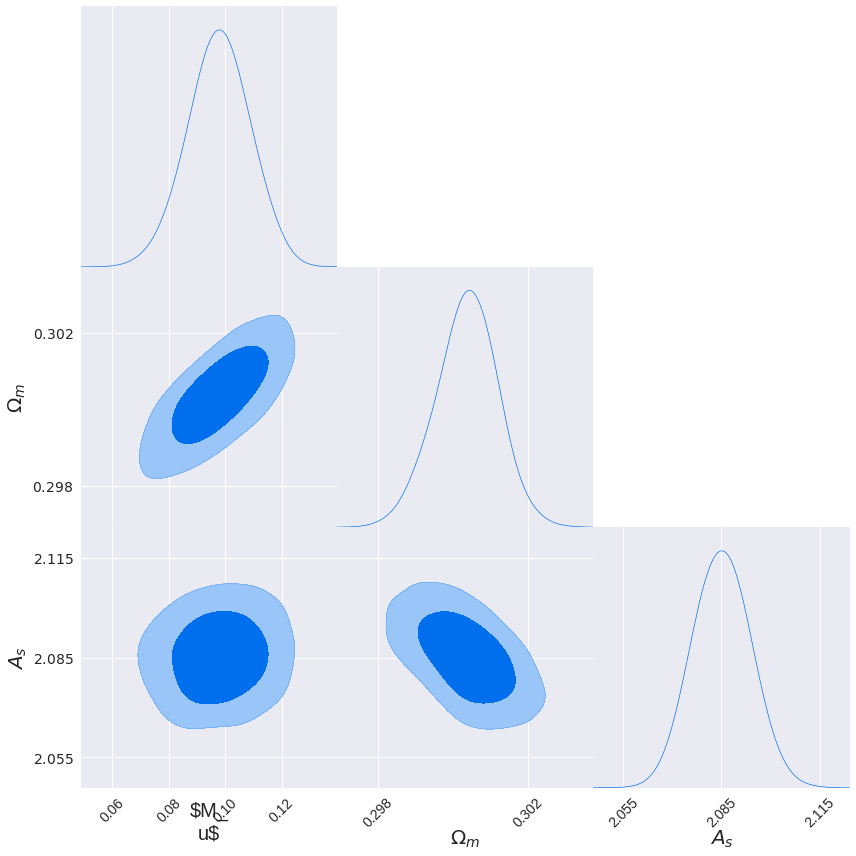

In [26]:
DelfiEnsemble.fisher_pretraining()

In [27]:
DelfiEnsemble.train_ndes()

In [0]:
posterior_samples = DelfiEnsemble.emcee_sample()

Removed no burn in


/usr/local/lib/python3.6/dist-packages/getdist/mcsamples.py:1775: RuntimeWarning: divide by zero encountered in true_divide
  bins2D /= a00
/usr/local/lib/python3.6/dist-packages/getdist/mcsamples.py:1775: RuntimeWarning: invalid value encountered in true_divide
  bins2D /= a00
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


DensitiesError: ignored

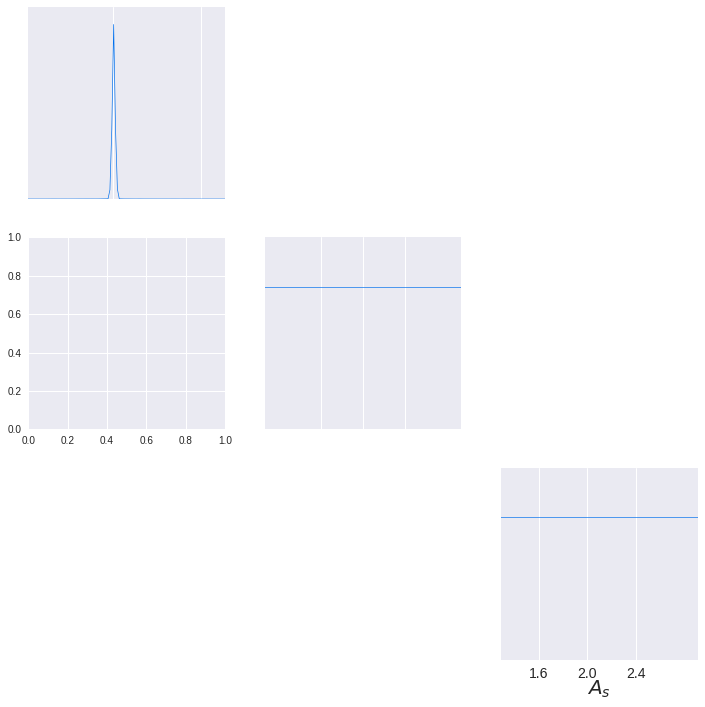

In [31]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples])

In [0]:
samples = []
for i in range(6):
    samples.append(DelfiEnsemble.emcee_sample(log_likelihood=lambda x: DelfiEnsemble.log_posterior_individual(i, x)))

Removed no burn in


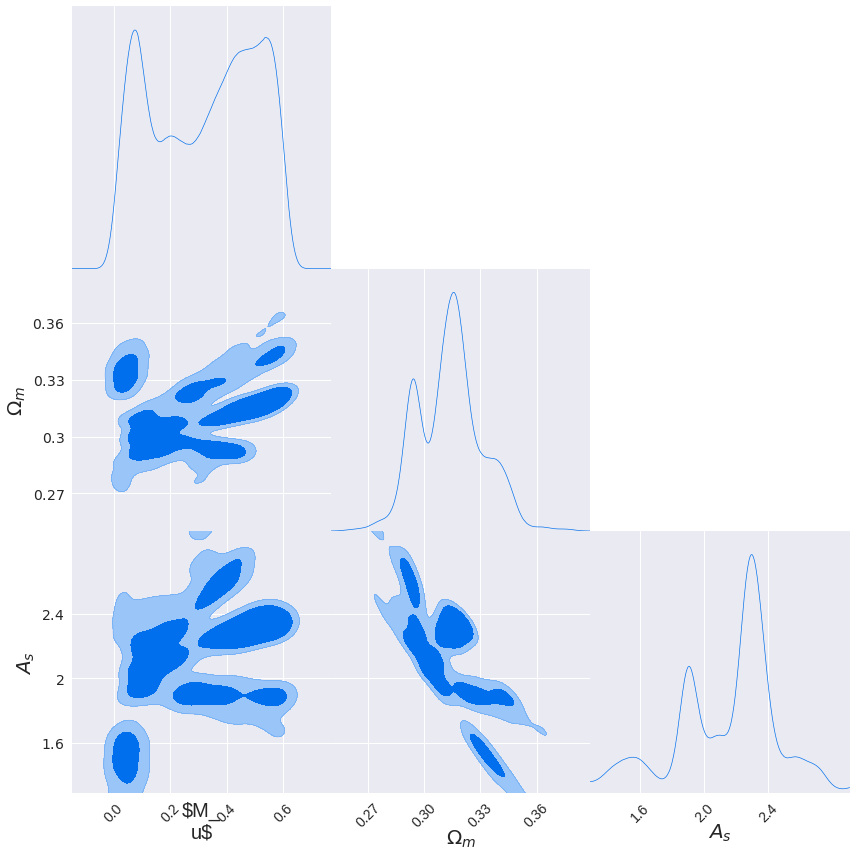

Removed no burn in


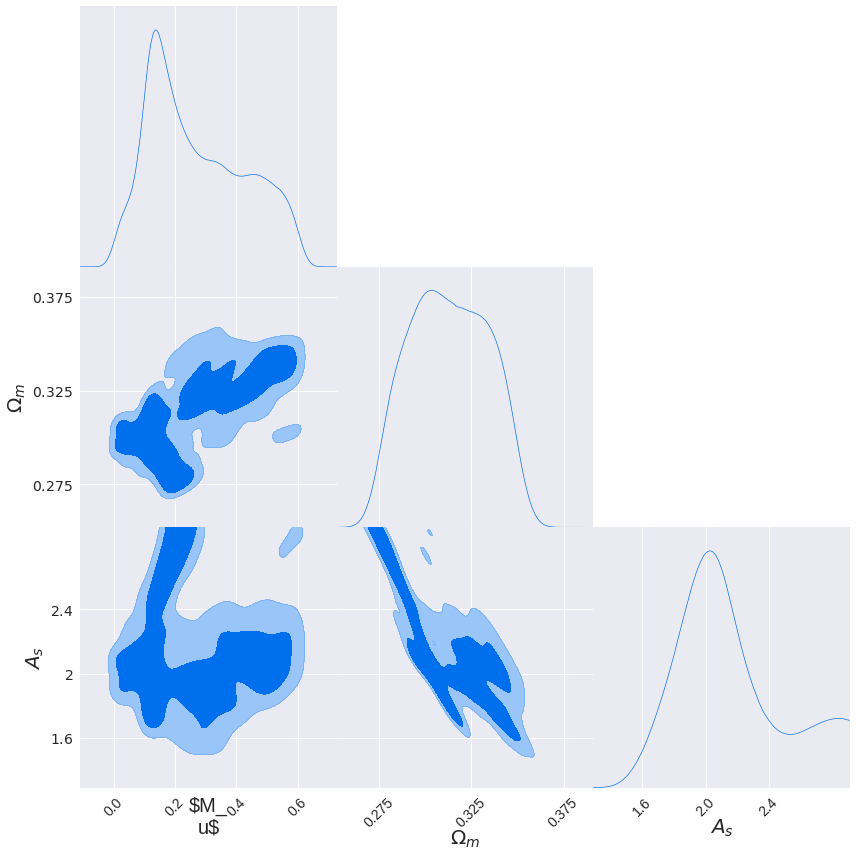

Removed no burn in


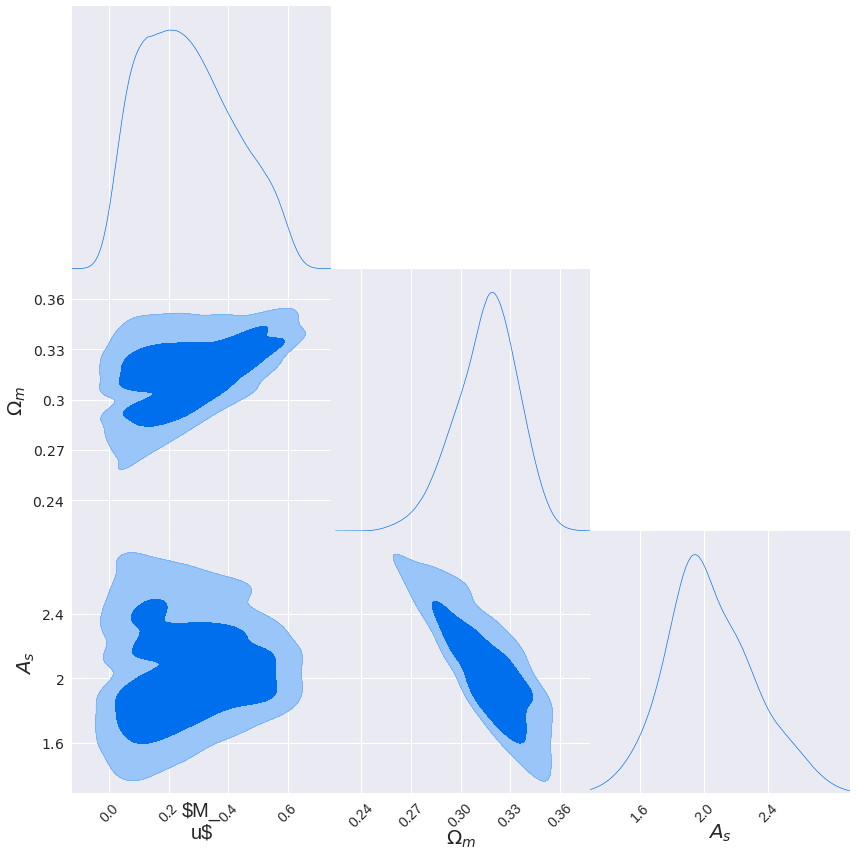

Removed no burn in


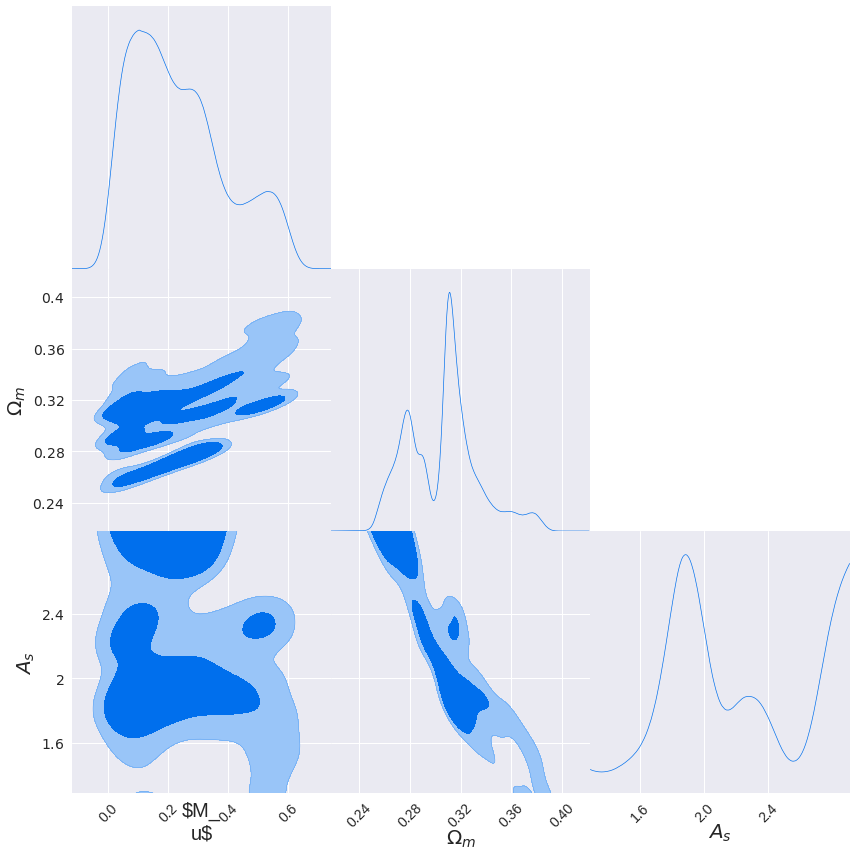

Removed no burn in


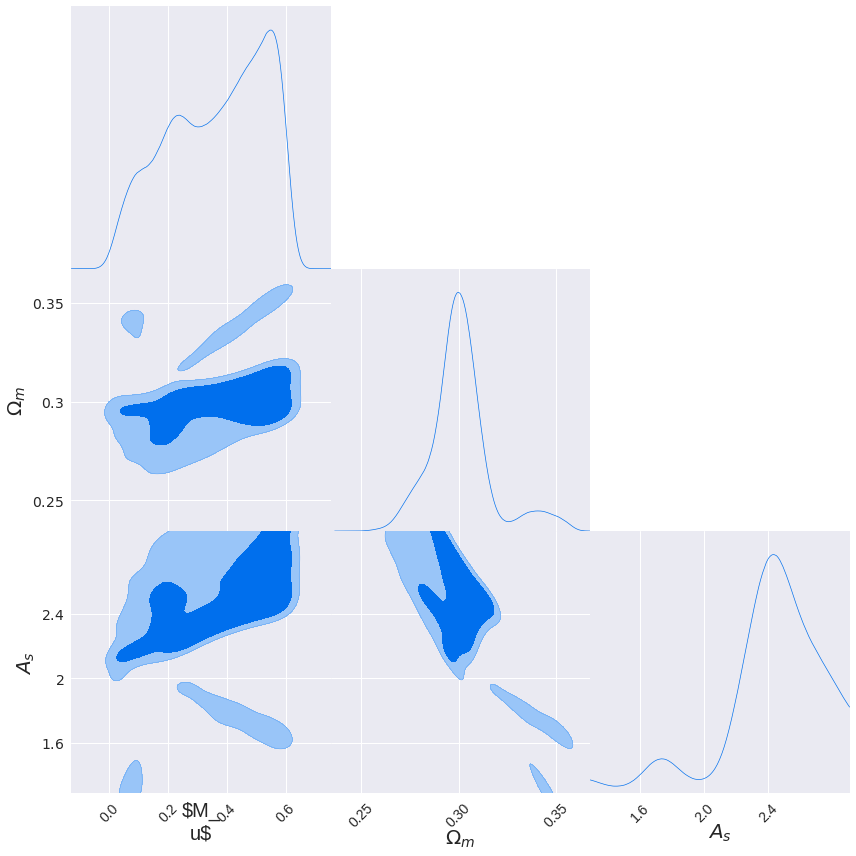

Removed no burn in


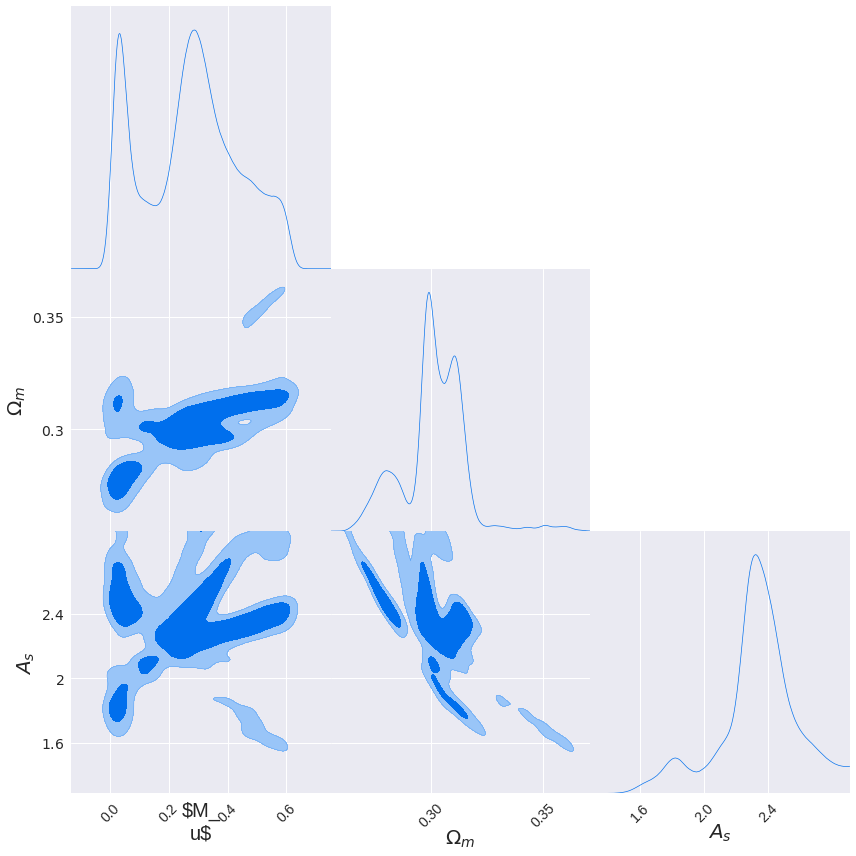

In [33]:
for i in range(6):
    DelfiEnsemble.triangle_plot(samples=samples[i:i+1])